In [1]:
import os
import re
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import json
from datetime import datetime
from dateutil.relativedelta import relativedelta
sns.set('paper','whitegrid', font_scale=2, rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

In [2]:
def get_action_dist(trades):
    action_dist = pd.Series(dtype=int)
    window_size = 5
    # num_bars = trades.iloc[-1]["ExitBar"] - trades.iloc[0]["EntryBar"] + 1
    num_bars = trades.iloc[-1]["ExitBar"] - window_size + 1
    action_list = np.zeros(num_bars)
    
    for trade in trades.itertuples():
        entry_index = trade.EntryBar - window_size
        exit_index = trade.ExitBar - window_size
        duration = int(trade.Duration.strip(" days"))
        if trade.Size == 0:
            action = 0
        elif trade.Size > 0:
            action = 1
        elif trade.Size < 0:
            action = -1
            
        
        action_list[entry_index:entry_index + duration - 1] = action
        action_list[exit_index] = 0
        
    action_dist.loc["Short"] = np.sum(action_list < 0)
    action_dist.loc["Neutral"] = np.sum(action_list == 0)
    action_dist.loc["Long"] = np.sum(action_list > 0)
    
    return action_dist

In [3]:
def get_summary_progress(local_dir: str, expt_name: str = None):
    summary_progress = {}
    expt_names = glob.glob(os.path.join(local_dir, "*_*"))
    for expt_name in expt_names:
        if "BuySell" in expt_name:
            continue
        algo, env_params, timelog = expt_name.split("\\")[-1].split("__")
        trials = glob.glob(os.path.join(expt_name, "ExperimentCV_*"))
        
        summary_trials = {}
        for trial in trials:
            with open(os.path.join(trial, "params.json"), 'r') as f:
                params = json.load(f)
            train_start = datetime.strptime(params["_train_start"], "%Y-%m-%d") + relativedelta(years=params["__trial_index__"])
            eval_start = datetime.strptime(params["_train_start"], "%Y-%m-%d") + relativedelta(years=params["__trial_index__"] + params["_train_years"])
            column_name = f"{train_start.year}(+{params['_train_years']}) | {eval_start.year}(+{params['_eval_years']})"
            
            # buy_hold_trades = pd.read_csv(os.path.join(trial, "buy-and-hold", "trades.csv"))
            trades_train = pd.read_csv(os.path.join(trial, "best-stats-train", "trades.csv"))
            trades_eval = pd.read_csv(os.path.join(trial, "best-stats-eval", "trades.csv"))
            action_dist_train = get_action_dist(trades_train)
            action_dist_train.name = "train"
            action_dist_eval = get_action_dist(trades_eval)
            action_dist_eval.name = "eval"
            
            action_dist = pd.concat([action_dist_train, action_dist_eval], axis=1)
            summary_trials[column_name] = action_dist
        
        summary_progress[f"{algo}_{env_params}"] = summary_trials

    return summary_progress

In [4]:
summary_action_dist = get_summary_progress("./ray_results/compare-action-3")

In [5]:
def plot_action_dist(summary_action_dist, target: str = "episode_reward_mean"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 9))
    title = "Action Distribution"
    ax[0].set_title(title + " (train)")
    ax[1].set_title(title + " (eval)")
    height_train = [0, 0, 0]
    height_eval = [0, 0, 0]
    for expt, trial_dict in summary_action_dist.items():
        expt = expt.replace("LongNeutralShort", "LNS")
        action_dist_cv_train = pd.DataFrame()
        action_dist_cv_eval = pd.DataFrame()
        for trial, action_dist in trial_dict.items():
            # target = action_dist[[target, "timesteps_total"]].set_index("timesteps_total")
            action_dist_cv_train = pd.concat([action_dist_cv_train, action_dist["train"]], axis=1)
            action_dist_cv_eval = pd.concat([action_dist_cv_eval, action_dist["eval"]], axis=1)
            # ax.plot(progress["timesteps_total"], progress[target], label=trial)
            
        action_dist_cv_train = action_dist_cv_train.mean(axis=1)
        action_dist_cv_eval = action_dist_cv_eval.mean(axis=1)
        print(expt)
        print(action_dist_cv_train)
        ax[0].bar(["Short", "Neutral", "Long"], action_dist_cv_train.values, bottom=height_train, label=expt)
        ax[1].bar(["Short", "Neutral", "Long"], action_dist_cv_eval.values, bottom=height_eval, label=expt)
        height_train += action_dist_cv_train.values
        height_eval += action_dist_cv_eval.values
        

    ax[0].grid(True)
    ax[1].grid(True)
    ax[0].legend(loc="upper left")
    ax[1].legend(loc="upper left")
    ax[0].set_ylabel("Count")
    ax[1].set_ylabel("Count")
    ax[0].set_ylim([0, 2500])
    ax[1].set_ylim([0, 500])
    # ax[0].set_xticks([-1, 0, 1])
    # ax[1].set_xticks([-1, 0, 1])
    # ax[0].set_xticklabels(["Short", "Neutral", "Long"])
    # ax[1].set_xticklabels(["Short", "Neutral", "Long"])

A2C_actions=LNS
Short      399.0
Neutral    299.0
Long       521.4
dtype: float64
DQN_actions=LNS
Short      375.6
Neutral    357.2
Long       436.6
dtype: float64
PPO_actions=LNS
Short      328.6
Neutral    458.8
Long       431.8
dtype: float64
SAC_actions=LNS
Short      323.2
Neutral    349.8
Long       544.6
dtype: float64


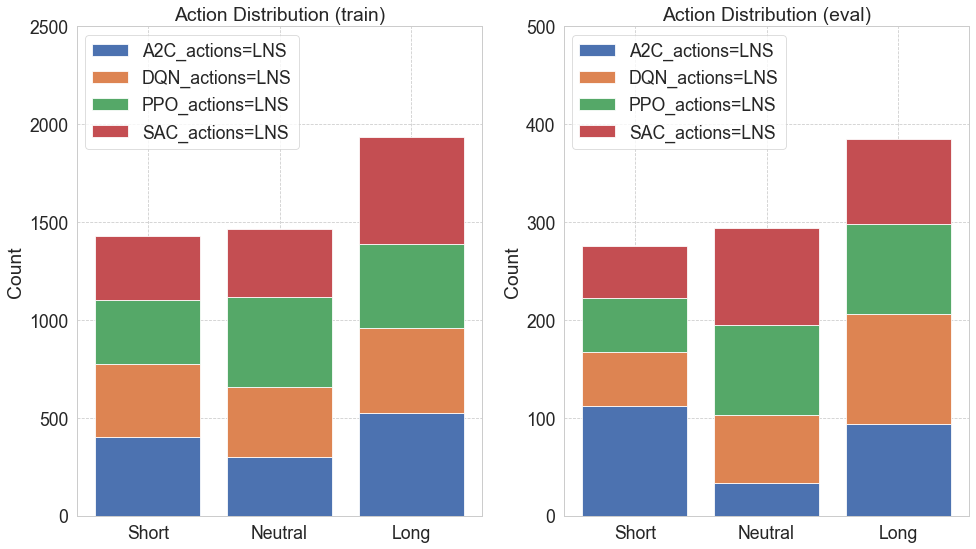

In [6]:
plot_action_dist(summary_action_dist)